<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/Practica7.5.%20Introducci%C3%B3n%20a%20VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Esta práctica está implementada con una versión anterior de Tensorflow
%tensorflow_version 1.x
import keras
keras.__version__

TensorFlow 1.x selected.


Using TensorFlow backend.


'2.3.1'

In [2]:
from keras import backend as K
K.clear_session()

# Práctica 7.5. Generando imágenes con VAEs

Muestrear de un espacio latente de imágenes para crear nuevas imágenes o editar existentes es una de las aplicaciones de la IA la más populares y creativas. En esta práctica revisaremos algunas de las técnicas relacionadas con la generación de imágenes: los autocodificadores variacionales (variational autoencoders, VAEs).

Estas técnicas, aunque aplicadas principalmente y con mayor éxito con imágenes, no son únicamente aplicables en este contexto. Se pueden aplicar a la generación de sonidos, música e incluso textos.

## 1. Muestreando el espacio latente.

La idea clave en la generación de imágenes es crear un espacio dimensional inferior de representaciones (que naturalmente es un espacio vectorial) donde cada punto puede ser mapeado a una imagen realista. El elemento capaz realizar este mapeo, dado un vector de entrada y dando una imagen de salida, es denominado como *generador* (en el caso de las GANs) o decodificador (en el caso de las VAEs). 

Una vez que ese espacio latente queda definido, podremos extraer un punto de él de manera concreta o aleatoria, y mapearlo a una imagen que nunca antes haya existido:

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/latent_vector_space.png?raw=1' width=70% />

Las GANs y las  VAEs son dos estrategias diferentes para aprender este espacio latente de representaciones de imágenes. Cada una de estas estrategias tiene sus propias propiedades. Las VAEs son muy buenas aprendiendo un espacio latente bien estructurado, donde las direcciones específicas codifican una significativa variación en los datos. Las GANs son capaces de generar imágenes muy realistas, pero el espacio latente del que provienen no tendrá una estructura o continuidad.

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/continuios_latent_space.png?raw=1' width=70% />


## 2. Vectores de concepto para edición

Ya hemos tocado la idea de *vector de concepto* cuando se vieron los *embeddings*. La idea es la misma: dado un espacio latente de representaciones ciertas direcciones en el espacio podrían codificar variaciones en los datos. Por ejemplo en un espacio latente de caras podrían haber vectores que condificaran la sonrisa. En tal caso un punto *z* es una representación de una cierta cara, entonces *z + s* debe ser la representación de la misma cara sonriendo.

Una vez que se ha identificado un vector es posible editar imágenes proyectándolas dentro del espacio latente, moviendo su representación dentro del espacio latente y por último decodificarlas al espacio de las imágenes.  Hay vectores de concepto por cada dimension de variación en la imagen. Continuando con el ejemplo de las caras, se podría encontrar vectores para agregar o quitar gafas, convertir una cara de hombre en una cara de mujer, etc. La siguiente imagen es un ejemplo de vector de sonrisa descubierto por Tom White de la Universidad de Victoria de Nueva Zelanda, usando una VAE entrenada con caras de famosas (CelebA dataset):

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/vae_smaile.png?raw=1' width=50% />


## 3. Autocodificadores Variacionales

Los autocodificadores variacionales fueron descubiertos simultáneamente por Kngma y Welling en Diciembre de 2013 y por Mohamed y Wierstra en Enero de 2014. Son un tipo de modelo generativo que es especialmente apropiado para la tarea de edición de imágenes a través de los vectores de concepto como ya hemos mencionado. 

Un autoencoder clásico toma una imagen y la mapea a un vector de un espacio latente al pasar por un "codificador". Posteriormente este vector pasa por el "decodificador" que transformará el vector en una imagen de las mismas dimensiones que la de la entrada. Se entrena usando como entrada y como salida las mismas imágenes, por lo debe aprender a reconstruir la imagen original. Habitualmente, se restringe la salida del codificador a una dimensionalidad muy pequeña y dispersa (mayormente ceros). En estos casos el codificador debe comprimir los datos en a pocos bits de información:


![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

En la práctica, los autocodificadores clásicos no dan lugar a espacios latentes útiles o bien estructurados. Tampoco son buenos para compresión. Por estas razones ha perdido interés en los últimos años. Los autoencoder variacionales, sin embargo, dotan a los autocodificadores clásicos de un poco de "magia" estadística que los fuerza a aprender espacios latentes continuos y bien estructurados. Esto los ha convertido en un herramienta muy interesante en la generación de imágenes.

Una VAE, en vez de comprimir la imagen a una codificación fija, convierte la imagen en parámetros estadísticos de una distribución estadística: media y varianza. Básicamente, esto significa que estamos asumiento que la imagen de entrada ha sido generada por un proceso estadístico, y la aletoriedad de este proceso debería ser tenido en cuenta durante la codificación y la decodificación. La característica estocástica de este proceso mejora la robustez y fuerza al espacio latente a crear representaciones útiles en cualquier lugar. Por ejemplo cada punto muestreado del espacio latente será decodificado a una salida válida.


![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

Un autocodificador variacional funciona de la siguiente forma:

 1. Un codificador convierte la entrada en dos parámetros del espacio latente de representaciones, *z_mean* y *z_log_variance*.
 2. Aleatoriamente, muestreamos un punto *z* de una distribución normal latente que asumimos que generó la imagen de entrada a través de *z = z_mean + exp(z_log_variance) * epsilon* donde *epsilon* es un tensor aleatorio con valores pequeños.
 3. Un decodificador mapea el punto en el espacio a la imagen original.
 
Al ser *epsilon* aleatorio, con este proceso aseguramos que cada punto cercano al punto del espacio latente correspondiente a la imagen de entrada podrá ser decodificada a algo similar a dicha imagen de entrada. Esto fuerza la continuidad en el espacio latente. Dos puntos cualesquiera cercanos entre sí deberán generar dos imágenes muy similares. La continuidad combinada con la baja dimensionalidad del espacio latente fuerza a que cada dirección en el espacio latente codifique variaciones de los datos importantes, haciendo que este espacio esté bien estructurado y susceptible a su manipulación mediante los vectores de concepto.

Los parámetros de la VAE son entrenados usando dos funciones de coste: la primera mide el nivel de reconstrucción del codificador-decodificador, la segunda es una funcion de regularización que ayuda a aprender espacios latentes bien formados y reducen el sobreajuste.

Esquemáticamente la implementación en Keras quedaría así:

```python
# Codificamos la entrada para obtener la media y la varianza
z_mean, z_log_variance = encoder(input_img)

# Muestreamos del espacio latente usando un pequeña perturbación 
# epsilon
z = z_mean + exp(z_log_variance) * epsilon

# Decodificamos el punto muestreado anteriormente para
# obtener una nueva imagen
reconstructed_img = decoder(z)

# Nuestro modelo
model = Model(input_img, reconstructed_img)

# Entrenamos el modelo usando dos funciones de coste:
# una función de coste de reconstrucción y una función de
# de coste de regularización
```

En primer lugar vamos a definir la red que hace de codificador. Ésta usará capas convolucionales para mapear la imagen de entrada *x* a los vectores *z_mean* y *z_long_variance*.

In [3]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
# Dimensionalidad del espacio latente: un plano
latent_dim = 2  

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


En Keras, necesitamos una capa que haga una operación, pero que no tenga que aprender nada. Nos la podemos definir rápidamente usando la función *Lambda*. La función *sample* implementa el muestreo visto anterior usando `z_mean` y `z_log_var`. 

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

El decodificador tendrá que mapear el vector *z* a las dimensiones de una imagen. Para ello usaremos tambien capas convolucionales para obtener dicha imagen. La salida de este red deberá ser la entrada del codificador.

Para ello debemos aplicar una operación de deconvolución o la traspuesta de la convolución:

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/conv_transposed.gif?raw=1' />

In [5]:
# La entrada con la dimensión de `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Interpolar (upsample) al número correcto de unidades
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# Redimensionar en una imagen del mismo shape de antes nuestra última capa `Flatten`
x = layers.Reshape(shape_before_flattening[1:])(x)

# Aplicamos la deconvolución
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)

# Es necesario aplicar una convolución adicional para
# obtener el mismo tamaño que la entrada
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# El modelo final
decoder = Model(decoder_input, x)

# Aplicamos el decoder a la salida del encoder
z_decoded = decoder(z)

La función de coste dual (reconstrucción-regularización) no se ajusta a la función habitual de coste que tiene la forma `loss(input, target)` en que la función de coste recibe dos parámetros. Necesitamos construir una capa personalizada para que internamente lleve a cabo la adición de los dos componentes usando *add_loss*:

In [6]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, img, z_decoded):
        x = K.flatten(img)
        z_decoded = K.flatten(z_decoded)
        
        # componente de reconstrucción
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # regularización KL-divergente
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), 
                                 axis=-1)
        
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        img = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(img, z_decoded)
        
        self.add_loss(loss, inputs=inputs)
        
        # No usaremos esta salida
        return x

# Nos construimos una capa que tiene como entradas
# la imagen original y la salida de codificador
y = CustomVariationalLayer()([input_img, z_decoded])

Por último, instanciamos y entrenamos el modelo. Dado que la función de coste se ha definio con nuestra capa personalizada no tenemos que especificar una función de coste externa al compilar el modelo y por tanto no tenemos por qué pasarle la respuesta esperada al modelo (no supervisado):

In [7]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Entrenar a la VAE en dígitos MNIST
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 503us/step - loss: 0.2321 - val_loss: 0.2114
Epoch 2/10
60000/60000 [==============================] - 23s 385us/step - loss: 0.2029 - val_loss: 0.1969
Epoch 3/10
60000/60000 [==============================] - 23s 380us/step - loss: 0.1949 - val_loss: 0.1925
Epoch 4/10
60000/60000 [==============================] - 22s 374us/step - loss: 0.1910 - val_loss: 0.1911
Epoch 5/10
60000/60000 [==============================] - 23s 377us/step - loss: 0.1884 - val_loss: 0.1866
Epoch 6/10
60000/60000 [==============================] - 23s 388us/step - loss: 0.1866 - val_loss: 0.1848
Epoch 7/10
60000/60000 [==============================] - 23s 388us/step - loss: 0.1853 - val_loss: 0.1848
Epoch 8/10
60000/60000 [=================

Una vez que el modelo es entrenado, en este caso hemos usado MNIST, podemos decodificar un conjunto de vectores arbitrariamente:

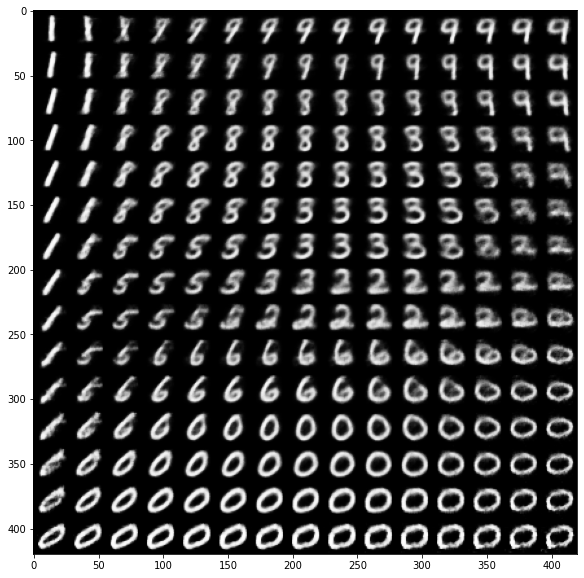

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

# Visualizar un colector 2D de los dígitos
n = 15  # figura con 15x15 dígitos
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Las coordenadas espaciadas linealmente en la unidad cuadrada fueron transformadas
# a través de la CDF inversa (ppf) del Gaussiano
# para producir valores de las variables latentes z,
# ya que el precursor del espacio latente es Gaussiano.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Esta matriz muestra la continuidad de la distribución de diferentes números creando un proceso de transformación (*morphing*) de uno a otro. Algunas direcciones de este espacio tienen significados diferentes. Por ejemplo hay una dirección para los "unos", "nueves", ...

Puedes ver una versión actualizada a TensorFlow 2 de este código en [la web de Keras](https://keras.io/examples/generative/vae/).